In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.constants import c, k_B, M_sun, G, m_p, sigma_sb, m_p
import astropy.units as u
from scipy.integrate import solve_ivp
from scipy.sparse import csr_matrix
from scipy.integrate import LSODA
import numpy as np
import numba
import sys

sys.path.append('../Numerical_methods')
from matrix_calculator import A_matrix
from scheme_calculator import forward_backward
from bachelor_funcs import Σ_initial, r_array, r_ghost, sA_ghost, A_ghost

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)

In [2]:
μ = 2.34    #(Hayashi 1981)
α_rφ = 8e-3

def Omega_kep(r):
    return np.sqrt((G * M_sun) / r**3)


def c_s(Ω,  Σ, α_rφ = 8e-3):
    return ((sigma_sb**(-1) * (μ * m_p / k_B)**(-4) * 3/4 * Ω * Σ * α_rφ)**(1/6)).to('m/s')

In [3]:
# Testing units and sizes - function can be found in the next terminal
'''
Σ = Σ_initial(r_array * u.au)

inner_1 = Σ * r_array**(2)
inner_2 = α_rφ * c_s(Omega_kep(r_array * u.au), Σ)**2
inner = inner_1 * inner_2
inner_unit = inner.unit

ghost_1 = np.array([inner[1].value])
ghost_2 = np.array([inner[-2].value])

inner_ghost = np.concatenate((ghost_1, np.array(inner), ghost_2)) * inner_unit


outer_ghost = 2 / ((r_ghost *u.au) * Omega_kep(r_ghost * u.au)) * (sA_ghost @ inner_ghost) * inner_unit
outer_unit = outer_ghost.unit
sec_dev = 1/(r_ghost * u.au) * (sA_ghost @ outer_ghost) * outer_unit


sec_dev.to('g/(cm2 * kyr)')'''

"\nΣ = Σ_initial(r_array * u.au)\n\ninner_1 = Σ * r_array**(2)\ninner_2 = α_rφ * c_s(Omega_kep(r_array * u.au), Σ)**2\ninner = inner_1 * inner_2\ninner_unit = inner.unit\n\nghost_1 = np.array([inner[1].value])\nghost_2 = np.array([inner[-2].value])\n\ninner_ghost = np.concatenate((ghost_1, np.array(inner), ghost_2)) * inner_unit\n\n\nouter_ghost = 2 / ((r_ghost *u.au) * Omega_kep(r_ghost * u.au)) * (sA_ghost @ inner_ghost) * inner_unit\nouter_unit = outer_ghost.unit\nsec_dev = 1/(r_ghost * u.au) * (sA_ghost @ outer_ghost) * outer_unit\n\n\nsec_dev.to('g/(cm2 * kyr)')"

In [4]:
def Σ_step_bound_old(Σ, Δt):
    inner_1 = Σ * r_array**(2)
    inner_2 = α_rφ * c_s(Omega_kep(r_array * u.au), Σ)**2
    inner = inner_1 * inner_2
    inner_unit = inner.unit

    ghost_1 = np.array([inner[1].value])
    ghost_2 = np.array([inner[-2].value])

    inner_ghost = np.concatenate((ghost_1, np.array(inner), ghost_2)) * inner_unit


    outer_ghost = 2 / ((r_ghost *u.au) * Omega_kep(r_ghost * u.au)) * (sA_ghost @ inner_ghost) * inner_unit
    outer_unit = outer_ghost.unit
    sec_dev = 1/(r_ghost * u.au) * (sA_ghost @ outer_ghost) * outer_unit


    return Σ + Δt * sec_dev[1: -1].to('g/(cm2 * yr)')

In [36]:
def Σ_step_bound(Σ, Δt):
    inner_1 = Σ * r_array**(2)
    inner_2 = α_rφ * c_s(Omega_kep(r_array * u.au), Σ)**2
    inner = inner_1 * inner_2
    inner_unit = inner.unit

    ghost_1 = np.array([inner[1].value])
    ghost_2 = np.array([inner[-2].value])

    inner_ghost = np.concatenate((ghost_1, np.array(inner), ghost_2)) * inner_unit

    bound = (sA_ghost @ inner_ghost) * inner_unit

    outer_ghost = 2 / ((r_ghost *u.au) * Omega_kep(r_ghost * u.au)) * bound
    outer_unit = outer_ghost.unit
    sec_dev = 1/(r_ghost * u.au) * (sA_ghost @ outer_ghost) * outer_unit


    return Σ + Δt * sec_dev[1: -1].to('g/(cm2 * kyr)')

[Text(0.5, 0, 'r [AU]'),
 Text(0, 0.5, 'Σ(r, t) [$g/cm^2$]'),
 Text(0.5, 1.0, 'Surface density\n$M_{disc}=0.11M_{sun}$'),
 None,
 None,
 (0.01, 100000000.0),
 (0.01, 300)]

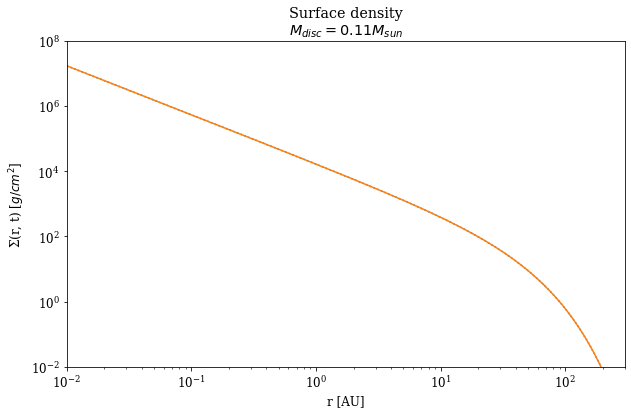

In [32]:
fig, axs = plt.subplots(figsize = (10, 6))

Δt = 1e-5 * u.kyr
Σ0 = Σ_initial(r_array * u.au)
res = Σ_step_bound(Σ0, Δt)

axs.loglog(r_array, Σ0, ls = ':',)
axs.loglog(r_array, res)
axs.set(xlabel = 'r [AU]', ylabel = 'Σ(r, t) [$g/cm^2$]', 
title = 'Surface density\n$M_{disc}=0.11M_{sun}$', yscale = 'log', xscale = 'log', ylim = (1e-2,1e8), xlim = (0.01, 300))

In [ ]:
Δt = 1e-5 * u.kyr
Σ0 = Σ_initial(r_array * u.au)
sol = []
Δt_solved = []
t_solved = []

rejected = 0
t = 0 * u.yr
step = 0
ε_rel = 2e-1
ε_abs = 1.5e-1
error_area = 1e0

t_final = 100 * u.kyr
while t <= t_final:
    res = Σ_step_bound(Σ0, Δt)

    δΣ = np.abs((res - Σ0) / (np.abs(Σ0) + ε_abs * Σ0.unit)).max()
    ε_tol = ε_rel

    Δt_next =  0.95*(ε_tol/δΣ) * Δt
    if Δt_next > 1.2 * Δt:
        Δt_next = 1.2 * Δt
    if Δt_next < 0.1 * Δt:
        Δt_next = 0.1 * Δt 

    if any(np.isnan(res)) == True:
        print('nan-value encountered')
        break

    if δΣ <= ε_tol:
        step += 1
        t += Δt
        sol.append(res)
        Σ0 = res
        Δt_solved.append(Δt.value)
        t_solved.append(t)
    else:
        rejected += 1    
    Δt = Δt_next
    
    #if step == 2e4:
        #print('Maximum steps attained')
        #break

In [45]:
print('Step and rejected steps:',step,',', rejected,'\nTotal time past', round(sum(Δt_solved)*1e3,2),'yr')

Step and rejected steps: 207309 , 93614 
Total time past 102.55 yr


[Text(0.5, 1.0, 'Δt')]

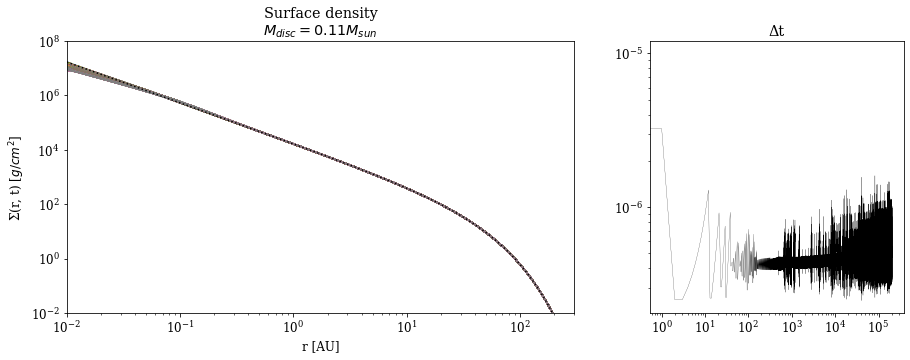

In [46]:
fig, axs = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios': [2, 1]})


for i in range(step):
    if i % 1000 == 0:
        axs[0].loglog(r_array, sol[i], '-')
axs[0].loglog(r_array,  Σ_initial(r_array * u.au), c = 'black', ls = ':')

axs[0].set(xlabel = 'r [AU]', ylabel = 'Σ(r, t) [$g/cm^2$]', 
title = 'Surface density\n$M_{disc}=0.11M_{sun}$', yscale = 'log', xscale = 'log', ylim = (1e-2,1e8), xlim = (0.01, 300));

axs[1].loglog(Δt_solved, c = 'black', lw = 0.2)
axs[1].set(title = 'Δt')